In [1]:
import torch
import torchvision.transforms as transforms
from progress.bar import Bar as Bar
import matplotlib.pyplot as plt
from loguru import logger as lgr
import numpy as np

from models.get_model import get_model

# Set parameters
Update `ckpt_path`, `backbone`, and `head` if necessary

In [2]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

opt = Namespace(
    ckpt_path="results/20240328-002135_deeplabv3p_deeplabv3p_head_mtl_baselines_vanilla_uniform_checkpoint.pth.tar",
    backbone='deeplabv3p',
    head='deeplabv3p_head', 

    is_distrib=True,
    method='vanilla', 
    pretrained=False,
    tasks=['water_mask', 'cloudshadow_mask', 'cloud_mask', 'snowice_mask', 'sun_mask'], 
    weight='uniform', 
)

# Load checkpoint

In [3]:
tasks = ["water_mask", "cloudshadow_mask", "cloud_mask", "snowice_mask", "sun_mask"]
num_inp_feats = 6   # number of channels in input
tasks_outputs_tmp = {
    "water_mask": 1,
    "cloudshadow_mask": 1,
    "cloud_mask": 1,
    "snowice_mask": 1,
    "sun_mask": 1,
}
tasks_outputs = {t: tasks_outputs_tmp[t] for t in tasks}
model = get_model(opt, tasks_outputs=tasks_outputs, num_inp_feats=num_inp_feats).cuda()

lgr.debug(f"Loading weights from {opt.ckpt_path}")
checkpoint = torch.load(opt.ckpt_path, weights_only=False)
if opt.is_distrib:
    new_ckpt = {k.split("module.")[-1]:v for k,v in checkpoint["state_dict"].items()}
    checkpoint["state_dict"] = new_ckpt
tmp = model.load_state_dict(checkpoint["state_dict"], strict=True)
lgr.debug(f"After loading ckpt: {tmp}")
lgr.debug(f"Checkpoint epoch: {checkpoint['epoch']}. best_perf: {checkpoint['best_performance']}")

model.eval()
print()

/home/rdaroya_umass_edu/miniconda3/envs/improv-mask/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-29 11:23:51.494 | DEBUG    | models.get_model:get_model:36 - encoder_weights: imagenet
2025-05-29 11:23:51.497 | DEBUG    | models.deeplabv3:__init__:451 - encoder_weights: imagenet
2025-05-29 11:23:51.966 | DEBUG    | models.get_model:get_model:80 - backbone_channels: 256
2025-05-29 11:23:52.195 | DEBUG    | __main__:<module>:13 - Loading weights from results/20240328-002135_deeplabv3p_deeplabv3p_head_mtl_baselines_vanilla_uniform_checkpoint.pth.tar
2025-05-29 11:23:52.448 | DEBUG    | __main__:<module>:19 - After loading ckpt: <All keys matched successfully>
2025-05-29 11:23:52.449 | DEBUG    | __main__:<module>:20 - Checkpoint epoch: 46. best_perf: 0.21422843215987086


# Load data

In [4]:
fp = "sample_data.npy" 
nodata_val = -9999
with open(fp, "rb") as f:
    npzfile = np.load(f)
    features = npzfile["features"]  # (512,512,6)
    snowice_mask = npzfile["snowice_mask"]
    water_mask = npzfile["water_mask"]  # (512,512)
    cloudshadow_mask = npzfile["cloudshadow_mask"]  # (512,512)
    cloud_mask = npzfile["cloud_mask"]  # (512,512)
    sun_mask = npzfile["sun_mask"]  # (512,512)
    fmask = npzfile["fmask_data"]

nodata_mask = (features==nodata_val).astype(int)
nodata_mask = nodata_mask[:512, :512, 0]    # only get 1st channel of features
feats_tmp = np.where(features==nodata_val, np.nanmax(features), features)
feats_min = np.nanmin(feats_tmp)
feats_tmp = np.where(features==nodata_val, feats_min, features)    # replace nodata values with minimum
feats_tmp = np.where(np.isnan(feats_tmp), feats_min, feats_tmp)    # replace nan values with minimum
feats_tmp = np.nan_to_num(feats_tmp, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
feats_tmp = (feats_tmp - np.nanmin(feats_tmp)) / np.maximum((np.nanmax(feats_tmp) - np.nanmin(feats_tmp)), 1)

data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

image = feats_tmp.astype(np.float32)
s1,s2 = snowice_mask.shape
snowice_mask = np.reshape(snowice_mask.astype(np.float32), (s1,s2,1))
water_mask = np.reshape(water_mask.astype(np.float32), (s1,s2,1))
cloudshadow_mask = np.reshape(cloudshadow_mask.astype(np.float32), (s1,s2,1))
cloud_mask = np.reshape(cloud_mask.astype(np.float32), (s1,s2,1))
sun_mask = np.reshape(sun_mask.astype(np.float32), (s1,s2,1))
all_data = np.concatenate((image, snowice_mask, water_mask, cloudshadow_mask, cloud_mask, sun_mask), axis=-1)

all_data = data_transforms(all_data)    # transform to tensor
all_data = all_data[:,:512, :512]   # only get upper left corner (NOTE: this is to avoid all no data values)
image = all_data[:6,:,:]
image = image - torch.min(image)
image = image / torch.maximum(torch.max(image),torch.tensor(1))
image = image.type(torch.FloatTensor)

snowice_mask = all_data[-5,:,:]
snowice_mask = torch.reshape(snowice_mask, (1,512,-1))
water_mask = all_data[-4,:,:]
water_mask = torch.reshape(water_mask, (1,512,-1))
cloudshadow_mask = all_data[-3,:,:]
cloudshadow_mask = torch.reshape(cloudshadow_mask, (1,512,-1))
cloud_mask = all_data[-2,:,:]
cloud_mask = torch.reshape(cloud_mask, (1,512,-1))
sun_mask = all_data[-1,:,:]
sun_mask = torch.reshape(sun_mask, (1,512,-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


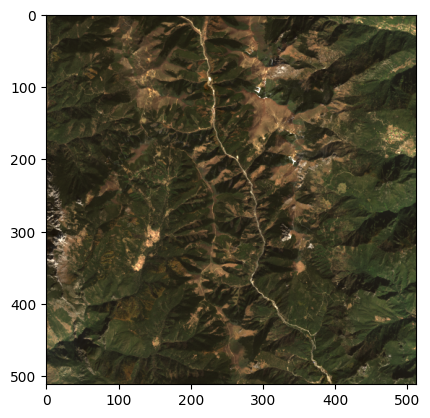

In [5]:
image_np = np.transpose(image.numpy(), (1,2,0))
rgb = image_np[:,:,:3][:,:,::-1]
print(rgb.shape)
plt.imshow(rgb*3)

# Run model on image

In [6]:
inp = torch.unsqueeze(image, 0)
pred, feat = model(inp.cuda(), feat=True)

# The following are the predictions across different masks. All are values from 0-1. You can choose to threshold them (see eval.py)
water_mask_pred = pred["water_mask"]
cloudshadow_mask_pred = pred["cloudshadow_mask"]
cloud_mask_pred = pred["cloud_mask"]
snowice_mask_pred = pred["snowice_mask"]
sun_mask_pred = pred["sun_mask"]

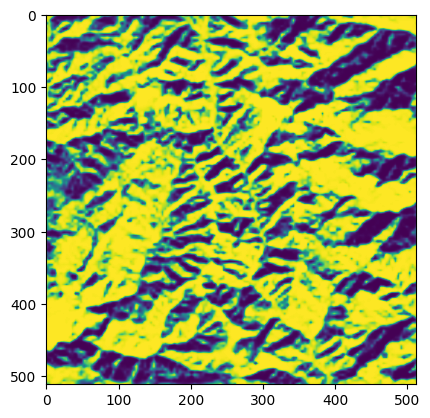

In [7]:
plt.imshow(sun_mask_pred.squeeze().detach().cpu().numpy())   # this is the shadow from the sun

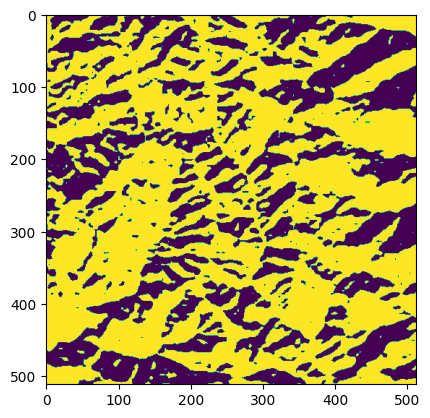

In [8]:
thresh_sun = np.where(sun_mask_pred.squeeze().detach().cpu().numpy()>0.5, 1, 0)  # you can also choose to threshold predictions
plt.imshow(thresh_sun)   # this is the shadow from the sun

# Display the ground truth mask

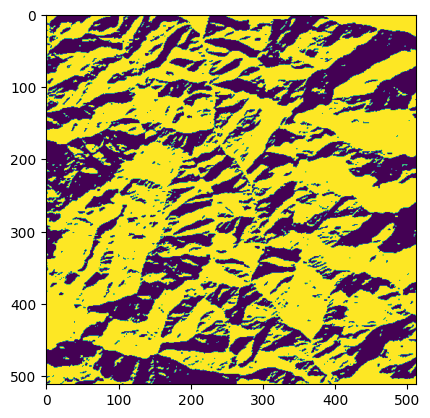

In [11]:
plt.imshow(sun_mask.squeeze().detach().cpu().numpy())   # this is the ground truth